In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import optimizers, Model, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, SpatialDropout1D, LSTM, Bidirectional, TimeDistributed, Input
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os, re, csv, math, codecs

In [4]:
import string
from bs4 import BeautifulSoup

In [5]:
sns.set_style("whitegrid")

In [6]:
MAX_NB_WORDS = 200000
tokenizer = RegexpTokenizer(r'\w+')

In [7]:
data = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [8]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
# deleting the article column
del data["article_link"]

In [10]:
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


###  Data Pre-processing

In [11]:
# Checking for NaN values
data.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

<Axes: xlabel='is_sarcastic', ylabel='count'>

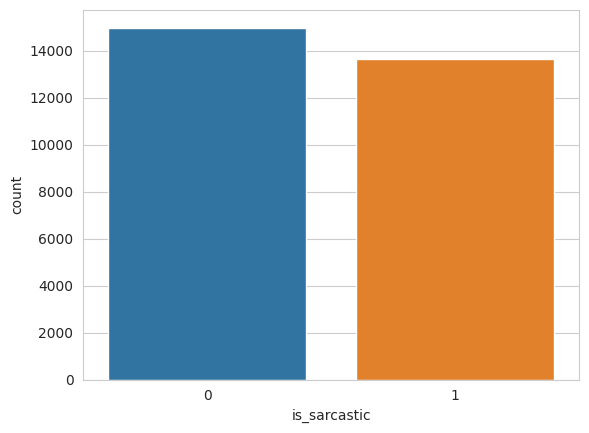

In [12]:
# Checking if the data is balanced
sns.set_style(style="whitegrid")
sns.countplot(x="is_sarcastic", data = data)

In [13]:
import nltk

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# creating a set of stopwords and punctuations
stopword = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stopword.update(punctuation)

In [16]:
# function to remove HTML tags
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [17]:
# function to remove square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]' , '' , text)

In [18]:
#function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [19]:
# function to remove stopwords
def remove_stopwords(text):
    corpus = []
    for i in text.split():
        if i.strip().lower() not in stopword:
            corpus.append(i.strip())
    return " ".join(corpus)

In [20]:
# functionn to denoise text
def denoise_text(text):
    text = remove_html(text)
    text = remove_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

In [21]:
# Applyig the denoise function for the corpus
data['headline'] = data['headline'].apply(denoise_text)

<ipython-input-16-1a60681daac9>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [22]:
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails congress falling short ...
2,0,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word 'streamin...


# Exploratory Data Analysis

In [23]:
from wordcloud import WordCloud,STOPWORDS

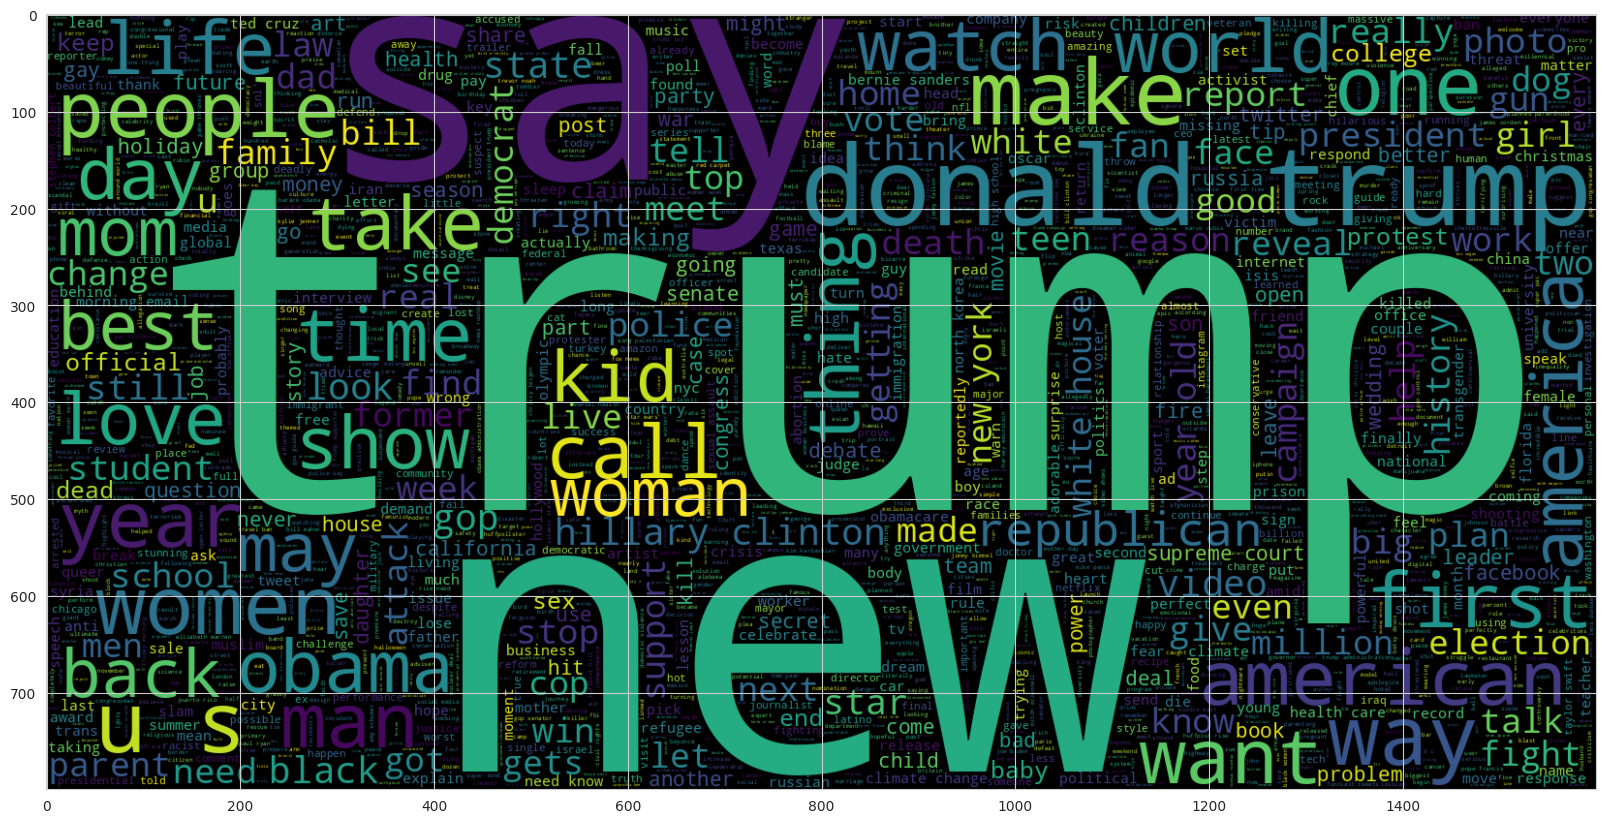

In [24]:
# Wordcloud for non sarcastic text
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(data[data.is_sarcastic == 0].headline))
plt.imshow(wc, interpolation = 'bilinear')

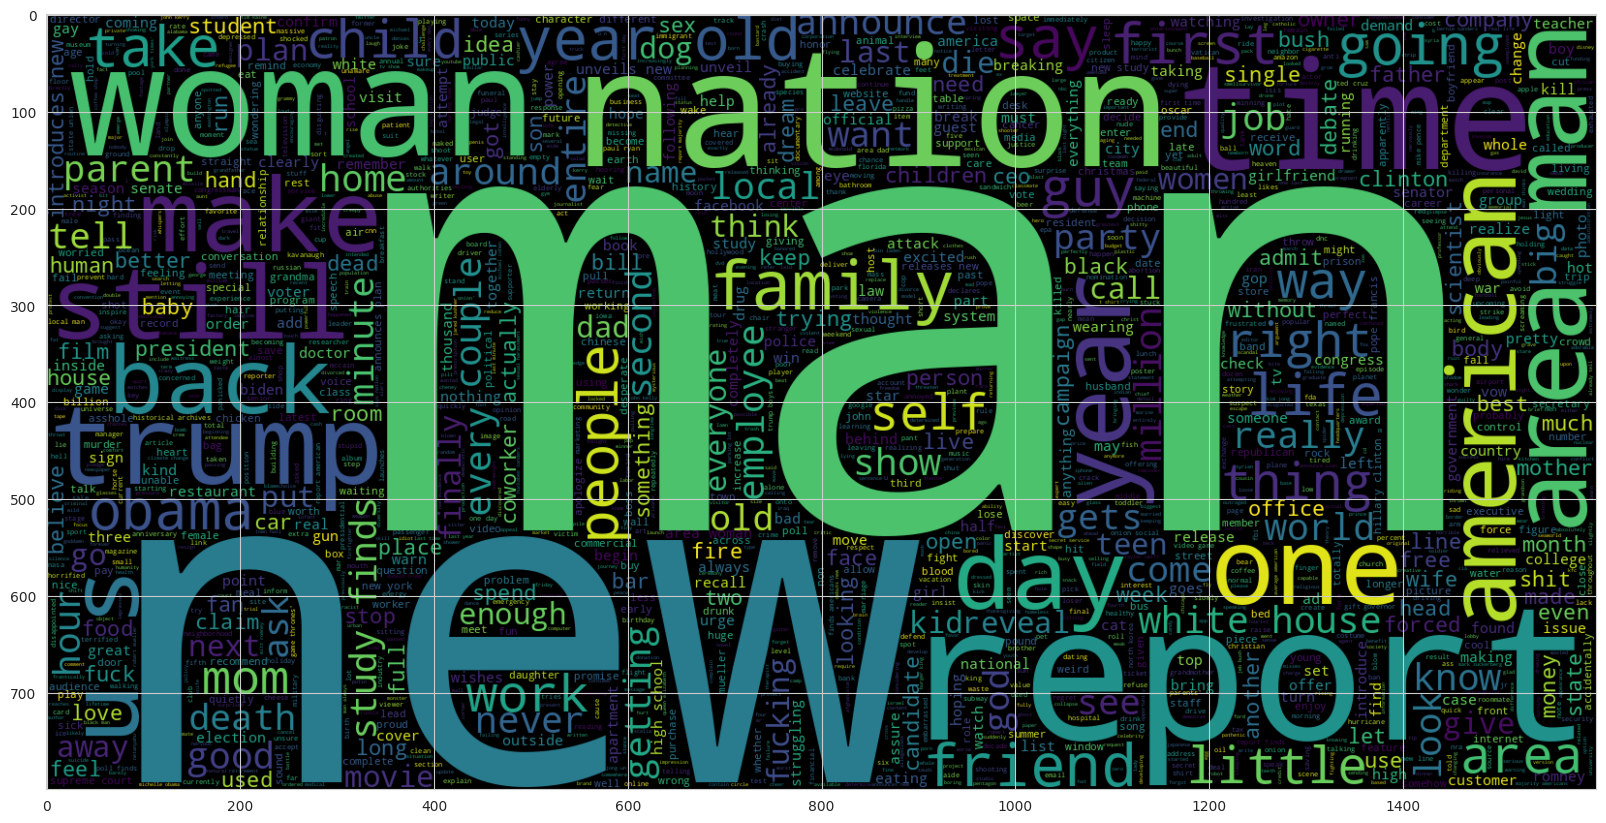

In [25]:
# Wordcloud for sarcastic text
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(data[data.is_sarcastic == 1].headline))
plt.imshow(wc, interpolation = 'bilinear')

###  Text count

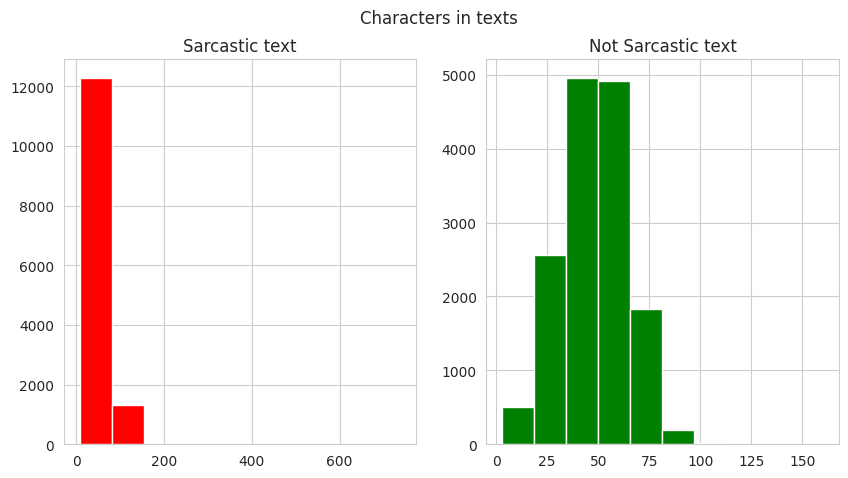

In [26]:
# plotting the number of characters in text
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = data[data['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len = data[data['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

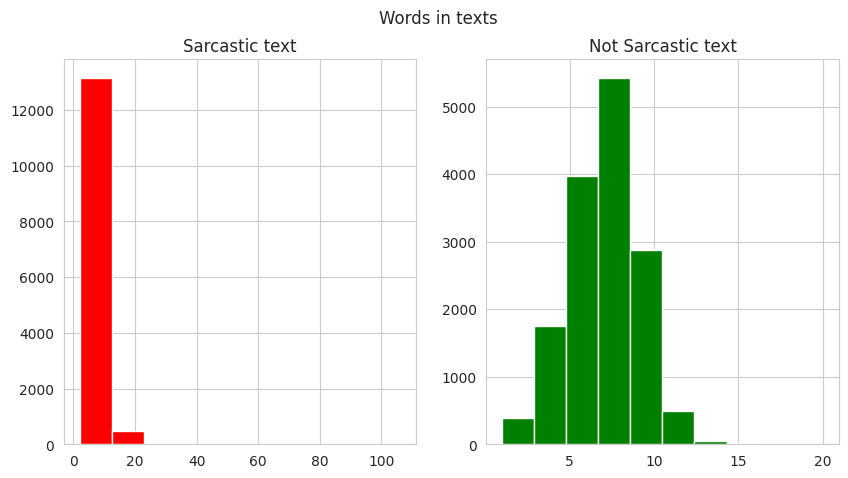

In [27]:
# plotting the number of words in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len = data[data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len = data[data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

<ipython-input-28-09865178c12a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
<ipython-input-28-09865178c12a>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each text')

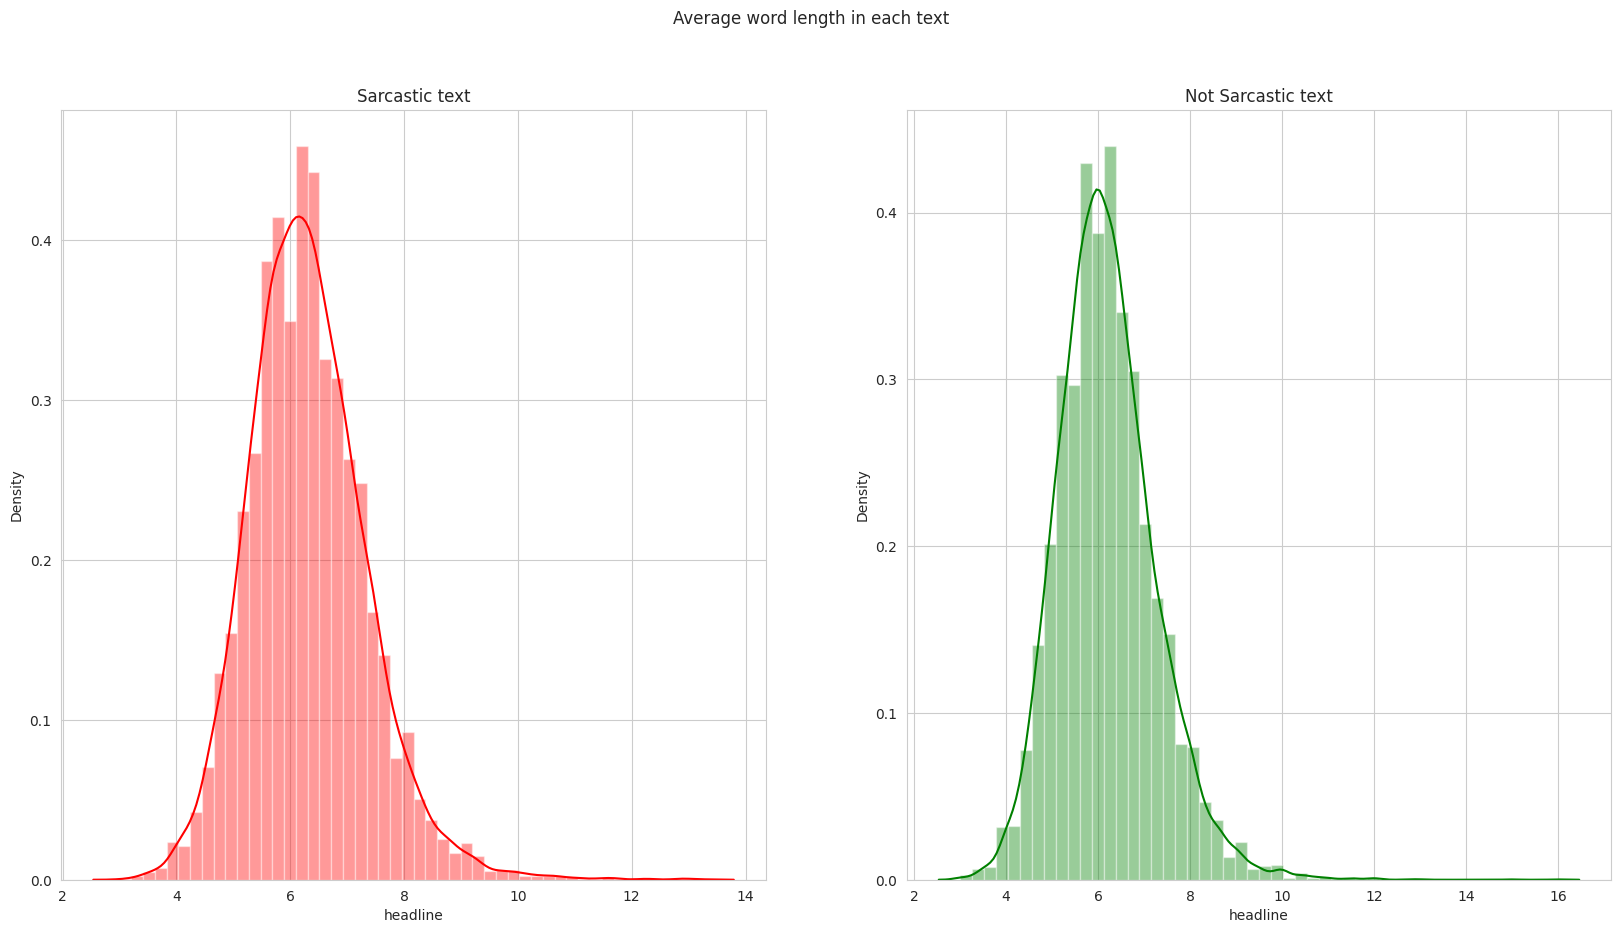

In [28]:
# plotting the average word length in a text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word = data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [29]:
data['headline'].str.len().max()

737

In [30]:
data['headline'].str.len().min()

3

In [31]:
data["headline"][0]

'thirtysomething scientists unveil doomsday clock hair loss'

In [32]:
count = 0
for i in range(len(data)):
    if len(data['headline'][i]) > 250:
        count += 1

In [33]:
count

1

In [34]:
count_1 = 0
for i in range(len(data)):
    if len(data['headline'][i]) > 200:
        count_1 += 1

In [35]:
count_1

3

In [36]:
count_2 = 0
for i in range(len(data)):
    if len(data['headline'][i]) > 150:
        count_2 += 1

In [37]:
count_2

8

In [38]:
count_3 = 0
for i in range(len(data)):
    if len(data['headline'][i]) > 100:
        count_3 += 1

In [39]:
count_3

216

In [40]:
count_4 = 0
for i in range(len(data)):
    if len(data['headline'][i]) > 90:
        count_4 += 1

In [41]:
count_4

572

In [42]:
len(data)

28619

It has been noticed that there is 1 headline with more than 250 words, 3 headlines with more than 200 words, 8 headlines with more than 150 words, 216 headlines with more than 100 words and 572 headlines with more than 90 words. Since 572 is low compared to 28619 we can delete these headlines as these may be considered as outliers.

In [43]:
mask = data['headline'].str.len() <= 90
data = data[mask]
data = data.reset_index(drop = True)

In [44]:
data

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails congress falling short ...
2,0,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word 'streamin...
...,...,...
28042,1,jews celebrate rosh hashasha something
28043,1,internal affairs investigator disappointed con...
28044,0,beautiful acceptance speech week came queer ko...
28045,1,mars probe destroyed orbiting spielberg-gates ...


# Building the model

In [45]:
!pip install transformers

In [46]:
from transformers import BertTokenizer, BertModel, TFBertModel

In [48]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [49]:
import tensorflow as tf

In [50]:
# Tokenize the sentences and obtain embeddings
def get_bert_embeddings(sentences):
    tokenized = tokenizer(sentences.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)
    outputs = model(**tokenized)
    last_hidden_states = outputs.last_hidden_state
    sentence_embeddings = tf.reduce_mean(last_hidden_states, axis=1)
    return sentence_embeddings.numpy()

In [51]:
# Get BERT embeddings for sentences
embeddings = get_bert_embeddings(data['headline'][:1000])

In [52]:
embeddings

array([[ 0.22667757,  0.38278216,  0.13790402, ..., -0.3458602 ,
         0.06446847, -0.21984483],
       [ 0.00573417, -0.50355864, -0.16621669, ..., -0.22150996,
        -0.2753041 , -0.10302607],
       [ 0.17212322,  0.04083433,  0.25711396, ...,  0.16538581,
         0.19811057,  0.00289524],
       ...,
       [ 0.24958545,  0.13350354,  0.45121717, ...,  0.2516875 ,
         0.287288  , -0.30181754],
       [ 0.12824552,  0.1154525 ,  0.1204783 , ..., -0.25765878,
         0.17176238, -0.14909492],
       [ 0.19175512, -0.33863032,  0.7372851 , ..., -0.46086374,
        -0.08492105,  0.03002877]], dtype=float32)

In [54]:
embeddings.shape

(1000, 768)

In [55]:
#training params
batch_size = 64
num_epochs = 8

In [56]:
#model parameters
num_filters = 128
num_kernels=200
stride=1
embed_dim = 300
weight_decay = 1e-4

In [57]:
#parallel layers
kernel_size=7
kernel_size_p1=3
kernel_size_p2=6
kernel_size_p3=9
kernel_size_p4=12

### CNNs

In [73]:
# CNN architecture
model = Sequential()
model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same', input_shape=(768,1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
# model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(2))
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dense(num_classes, activation='sigmoid'))  # multi-label (k-hot encoding)
model.add(Dense(1, activation='sigmoid'))

In [74]:
from tensorflow.keras.optimizers import Adam

In [75]:
# Compile and train the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 768, 200)          1600      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 384, 200)          0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 384, 200)          280200    
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 192, 200)          0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_3 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                      

In [76]:
# Split the data into training and testing sets
X = embeddings
y = data['is_sarcastic'][:1000].values

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Assuming you have labels y_train
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, shuffle=True)

Epoch 1/20
12/12 [==============================] - 14s 1s/step - loss: 0.7091 - accuracy: 0.5014 - val_loss: 0.6935 - val_accuracy: 0.4500
Epoch 2/20
12/12 [==============================] - 19s 2s/step - loss: 0.6961 - accuracy: 0.5153 - val_loss: 0.6875 - val_accuracy: 0.5500
Epoch 3/20
12/12 [==============================] - 14s 1s/step - loss: 0.6942 - accuracy: 0.5181 - val_loss: 0.6856 - val_accuracy: 0.5500
Epoch 4/20
12/12 [==============================] - 14s 1s/step - loss: 0.6967 - accuracy: 0.5292 - val_loss: 0.6862 - val_accuracy: 0.6875
Epoch 5/20
12/12 [==============================] - 14s 1s/step - loss: 0.6914 - accuracy: 0.5208 - val_loss: 0.6812 - val_accuracy: 0.5500
Epoch 6/20
12/12 [==============================] - 14s 1s/step - loss: 0.6859 - accuracy: 0.5556 - val_loss: 0.6818 - val_accuracy: 0.5500
Epoch 7/20
12/12 [==============================] - 15s 1s/step - loss: 0.6979 - accuracy: 0.5417 - val_loss: 0.6880 - val_accuracy: 0.4625
Epoch 8/20
12/12 [==

### BiLSTMs

In [80]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense

In [85]:
# Define input shape
input_shape = (768,1)

# Create a Sequential model
model = tf.keras.Sequential()
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))
model.add(Dense(1, activation='sigmoid'))

In [86]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [87]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 768, 256)          133120    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 188865 (737.75 KB)
Trainable params: 188865 (737.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
model.fit(X_train, y_train, batch_size = 128 , validation_data = (X_test,y_test) , epochs = 5)

Epoch 1/5
7/7 [==============================] - 134s 17s/step - loss: 0.6954 - acc: 0.5263 - val_loss: 0.6784 - val_acc: 0.5800
Epoch 2/5
7/7 [==============================] - 105s 14s/step - loss: 0.6850 - acc: 0.5537 - val_loss: 0.6775 - val_acc: 0.5950
Epoch 3/5
7/7 [==============================] - 104s 15s/step - loss: 0.6802 - acc: 0.5750 - val_loss: 0.6660 - val_acc: 0.6050
Epoch 4/5
7/7 [==============================] - 103s 15s/step - loss: 0.6840 - acc: 0.5650 - val_loss: 0.6571 - val_acc: 0.5850
Epoch 5/5
7/7 [==============================] - 108s 15s/step - loss: 0.6771 - acc: 0.5700 - val_loss: 0.6586 - val_acc: 0.6150


In [90]:
y_pred = model.predict(X_test)

7/7 [==============================] - 8s 1s/step


In [93]:
threshold = 0.5

In [91]:
from sklearn.metrics import classification_report

In [94]:
y_pred_binary = np.where(y_pred > threshold, 1, 0)

In [96]:
from sklearn.metrics import accuracy_score

In [98]:
accuracy_score(y_test, y_pred_binary)

0.615

# Attention BiLSTMs


In [99]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

In [100]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zeros',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = tf.reshape(tf.matmul(tf.reshape(x, (-1, features_dim)),
                                   tf.reshape(self.W, (features_dim, 1))),
                         (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = tf.tanh(eij)

        a = tf.exp(eij)

        if mask is not None:
            a *= tf.cast(mask, tf.float32)

        a /= tf.cast(tf.reduce_sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.float32)

        a = tf.expand_dims(a, axis=-1)
        weighted_input = x * a
        return tf.reduce_sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim


In [135]:
# Define input shape
input_shape = (768,1)

# Create a Sequential model
model = tf.keras.Sequential()
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))
model.add(Attention(768))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [137]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [138]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (None, 768, 256)          133120    
 ional)                                                          
                                                                 
 attention_6 (Attention)     (None, 256)               1024      
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 1)                 257       
                                                                 
Total params: 200193 (782.00 KB)
Trainable params: 200193 (782.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
tokenizer.vocab_size

30522

In [139]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Epoch 1/8
12/12 [==============================] - 62s 5s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.5500
Epoch 2/8
12/12 [==============================] - 65s 5s/step - loss: 0.6921 - accuracy: 0.5264 - val_loss: 0.6899 - val_accuracy: 0.5500
Epoch 3/8
12/12 [==============================] - 56s 5s/step - loss: 0.6921 - accuracy: 0.5264 - val_loss: 0.6889 - val_accuracy: 0.5500
Epoch 4/8
12/12 [==============================] - 54s 5s/step - loss: 0.6925 - accuracy: 0.5264 - val_loss: 0.6889 - val_accuracy: 0.5500
Epoch 5/8
12/12 [==============================] - 54s 4s/step - loss: 0.6919 - accuracy: 0.5264 - val_loss: 0.6893 - val_accuracy: 0.5500
Epoch 6/8
12/12 [==============================] - 56s 4s/step - loss: 0.6919 - accuracy: 0.5264 - val_loss: 0.6894 - val_accuracy: 0.5500
Epoch 7/8
12/12 [==============================] - 56s 5s/step - loss: 0.6918 - accuracy: 0.5264 - val_loss: 0.6896 - val_accuracy: 0.5500
Epoch 8/8
12/12 [==========

In [142]:
y_pred = model.predict(X_test)

7/7 [==============================] - 6s 864ms/step


In [141]:
threshold = 0.5

In [143]:
y_pred_binary = np.where(y_pred > threshold, 1, 0)

In [144]:
accuracy_score(y_test, y_pred_binary)

0.6